# What is Homography? How to estimate homography between two images?
Last Updated : 23 Jul, 2025

Homography is a fundamental concept in computer vision that describes the relationship between two different perspectives of a planar surface. It allows us to map points from one image to another, as long as the images capture the same scene from different viewpoints. Homographies are widely used in applications such as image stitching, 3D reconstruction, and augmented reality.
In this article, we'll explore the concept of homography, its mathematical representation, and the steps involved in estimating homography between two images.

## What is Homography?
Homography is a transformation matrix that defines a projective transformation between two images. It is a 3x3 matrix that relates the pixel coordinates of one image to the pixel coordinates of another image. If the two images depict the same scene from different viewpoints, and the scene lies on a plane, homography can be used to warp one image onto another.
Mathematically, if (x1,y1) and (x2,y2) are the corresponding points in two images, the homography matrix H relates them as follows:

\[
\begin{pmatrix} x_2 \\ y_2 \\ 1 \end{pmatrix} = H \cdot \begin{pmatrix} x_1 \\ y_1 \\ 1 \end{pmatrix}
\]

The matrix H is defined as:

\[
H = \begin{pmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{pmatrix}
\]

## Applications of Homography
- Image Stitching: Aligns images to create a panoramic view by warping them using homography.
- Augmented Reality: Projects virtual objects onto real-world surfaces by estimating the homography between the camera view and the real-world plane.
- Planar Object Detection: Identifies and tracks objects by estimating their homography in different images or video frames.
- 3D Reconstruction: Helps recover 3D geometry from multiple images.

## Estimating Homography Between Two Images
Estimating homography involves finding a matrix that relates corresponding points in two images. The process typically follows these steps:
1. Feature Detection
The first step is to detect key feature points in both images. These points represent distinctive parts of the image, such as edges, corners, or textures. Popular algorithms used for feature detection include:
- SIFT (Scale-Invariant Feature Transform)
- SURF (Speeded-Up Robust Features)
- ORB (Oriented FAST and Rotated BRIEF)

2. Feature Matching
Once feature points are detected, the next step is to match corresponding points between the two images. This is done by comparing the descriptors of each feature point and finding the ones that match most closely. This step is critical for establishing the relationship between the two images.
Popular methods for feature matching include:
- Brute-Force Matching: Compares descriptors of each feature point to find the closest match.
- FLANN (Fast Library for Approximate Nearest Neighbors): A faster, approximate method for matching features.

3. Estimating the Homography Matrix
Once corresponding points are found, the homography matrix can be estimated. The Direct Linear Transformation (DLT) algorithm is commonly used for this purpose.
If we have four pairs of corresponding points, the homography matrix H can be estimated by solving a system of linear equations. Given more than four points, a least-squares optimization is used to find the best fit for H.

4. RANSAC Algorithm for Robust Estimation
In practice, not all feature matches are correct due to noise or outliers. The RANSAC (Random Sample Consensus) algorithm is often used to improve the robustness of the homography estimation. It works by iteratively selecting a subset of point correspondences, estimating the homography matrix, and evaluating how well the matrix maps other points. Points that don’t fit well are considered outliers and are discarded.

5. Warping One Image Onto Another
Once the homography matrix is computed, we can warp one image onto the other using the matrix H. This is done by applying a projective transformation to each pixel of the first image to map it to its corresponding location in the second image.

## Estimating Homography Using RANSAC Algorithm
Here’s a basic code that demonstrates how to estimate homography between two images and warp one onto the other. You can load the image1 and image2.

1. Feature Detection: ORB (Oriented FAST and Rotated BRIEF) is used to detect keypoints and compute descriptors in both images.

2. Feature Matching: The Brute Force matcher is used to match the descriptors between the two images.

3. Homography Estimation: The homography matrix is estimated using the RANSAC algorithm to handle outliers.

4. Image Warping: The first image is warped to align with the second image using the homography matrix.

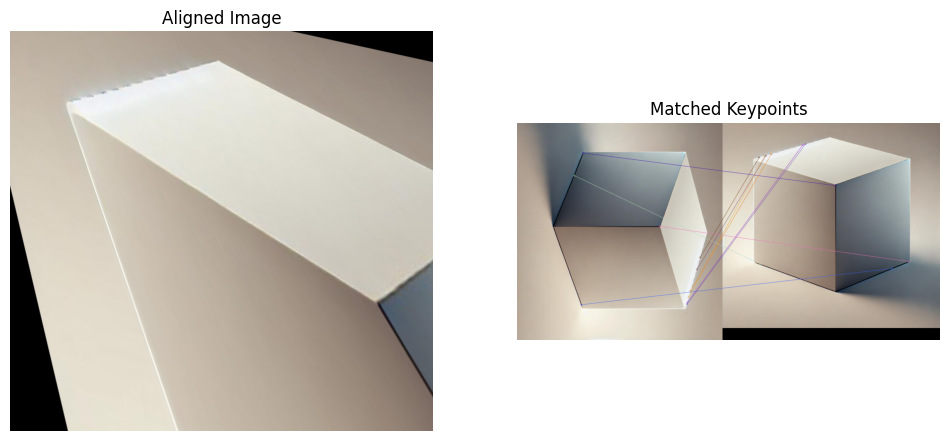

Images saved as 'aligned_image.jpg' and 'matches.jpg' in your working directory.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images (ensure 'image1.jpg' and 'image2.jpg' exist in your working directory)
img1 = cv2.imread('images/image1.jpg')
img2 = cv2.imread('images/image2.jpg')

if img1 is None or img2 is None:
    print("Error: Could not load images. Check file paths and ensure they exist.")
else:
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    if des1 is None or des2 is None:
        print("Error: No descriptors found in one or both images.")
    else:
        # Use BFMatcher to find matches between descriptors
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)

        if len(matches) < 4:
            print("Error: Not enough matches found (need at least 4 for homography).")
        else:
            # Sort matches by distance (best matches first)
            matches = sorted(matches, key=lambda x: x.distance)

            # Draw top 10 matches
            img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

            # Extract location of good matches
            pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

            # Find the homography matrix using RANSAC
            H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

            if H is None:
                print("Error: Could not compute homography matrix.")
            else:
                # Use the homography matrix to warp img1 to match img2
                height, width, _ = img2.shape
                img1_aligned = cv2.warpPerspective(img1, H, (width, height))

                # Display using matplotlib (convert BGR to RGB for correct colors)
                plt.figure(figsize=(12, 6))

                plt.subplot(1, 2, 1)
                plt.title('Aligned Image')
                plt.imshow(cv2.cvtColor(img1_aligned, cv2.COLOR_BGR2RGB))
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.title('Matched Keypoints')
                plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
                plt.axis('off')

                plt.show()

                # Save the output images locally
                cv2.imwrite('images/aligned_image.jpg', img1_aligned)
                cv2.imwrite('images/matches.jpg', img_matches)
                print("Images saved as 'aligned_image.jpg' and 'matches.jpg' in your working directory.")

## Output:
The code will display the aligned image and matched keypoints when run with actual images.

## Conclusion
Homography is a key concept for aligning images that capture the same scene from different viewpoints. By detecting features, matching points, and using algorithms like RANSAC, we can estimate the homography matrix that relates the two images. The applications of homography are vast, from image stitching to augmented reality and 3D reconstruction.